# **Set Up**

In [ ]:
import mlflow
mlflow.__version__

'3.7.0'

In [ ]:
# Connect to remote MLflow server
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("my-first-experiment")

<Experiment: artifact_location='file:C:/Users/admin2/artifacts/1', creation_time=1765232169340, experiment_id='1', last_update_time=1765232169340, lifecycle_stage='active', name='my-first-experiment', tags={}>

In [ ]:
# Connect to remote MLflow server
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("my-second-experiment")

<Experiment: artifact_location='file:C:/Users/admin2/artifacts/2', creation_time=1765232200722, experiment_id='2', last_update_time=1765232200722, lifecycle_stage='active', name='my-second-experiment', tags={}>

In [ ]:
# Print connection information
print(f"MLflow Tracking URI: {mlflow.get_tracking_uri()}")
print(f"Active Experiment: {mlflow.get_experiment_by_name('my-first-experiment')}")

MLflow Tracking URI: http://localhost:5000
Active Experiment: <Experiment: artifact_location='file:C:/Users/admin2/artifacts/1', creation_time=1765232169340, experiment_id='1', last_update_time=1765232169340, lifecycle_stage='active', name='my-first-experiment', tags={}>


In [ ]:
!pip install kagglehub

In [ ]:
!pip install tensorflow

# **Inporting The Libraries**

In [ ]:
# Import necessary libraries
import kagglehub
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path
from PIL import Image
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import json

**Downloading The Dataset**

In [ ]:
#Download dataset from Kaggle
import kagglehub
path = kagglehub.dataset_download("gti-upm/leapgestrecog")
print("Raw download path:", path)

Raw download path: C:\Users\admin2\.cache\kagglehub\datasets\gti-upm\leapgestrecog\versions\1


# **Setting New MLflow Experiment**

In [ ]:
mlflow.set_experiment("Hand_gesture MLflow ")

<Experiment: artifact_location='file:C:/Users/admin2/artifacts/3', creation_time=1765360848260, experiment_id='3', last_update_time=1765360848260, lifecycle_stage='active', name='Hand_gesture MLflow ', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [ ]:
root_dir = Path(path) / "leapGestRecog" / "leapGestRecog"

print("Using root folder:", root_dir)

subjects = sorted([d for d in os.listdir(root_dir) if not d.startswith('.')])
print("Found subject folders:", subjects)

Using root folder: C:\Users\admin2\.cache\kagglehub\datasets\gti-upm\leapgestrecog\versions\1\leapGestRecog\leapGestRecog
Found subject folders: ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09']


# **Preprocessing**

In [ ]:
IMG_SIZE = 128

x_data = []
y_labels = []
gesture_names = []
subject_ids = []

label_lookup = {}   # gesture_name -> int
reverse_lookup = {} # int -> gesture_name
label_count = 0


for subject in sorted(os.listdir(root_dir)):
    if subject.startswith('.'):
        continue
    subject_path = root_dir / subject
    if not subject_path.is_dir():
        continue

    for gesture in sorted(os.listdir(subject_path)):
        if gesture.startswith('.'):
            continue
        gesture_path = subject_path / gesture
        if not gesture_path.is_dir():
            continue

        if gesture not in label_lookup:
            label_lookup[gesture] = label_count
            reverse_lookup[label_count] = gesture
            label_count += 1

        label_idx = label_lookup[gesture]

        for img_name in os.listdir(gesture_path):
            if img_name.startswith('.'):
                continue
            img_path = gesture_path / img_name

            try:
                img = Image.open(img_path).convert("L")
                img = img.resize((IMG_SIZE, IMG_SIZE))
                img_arr = np.array(img)

                x_data.append(img_arr)
                y_labels.append(label_idx)
                gesture_names.append(gesture)
                subject_ids.append(subject)
            except Exception as e:
                print("Error reading", img_path, ":", e)

In [ ]:
x_data = np.array(x_data)
y_labels = np.array(y_labels)

print("x_data shape:", x_data.shape)
print("Number of samples:", len(x_data))
print("Number of classes:", len(label_lookup))
print("Classes mapping:", label_lookup)

x_data shape: (20000, 128, 128)
Number of samples: 20000
Number of classes: 10
Classes mapping: {'01_palm': 0, '02_l': 1, '03_fist': 2, '04_fist_moved': 3, '05_thumb': 4, '06_index': 5, '07_ok': 6, '08_palm_moved': 7, '09_c': 8, '10_down': 9}


In [ ]:
#Resizing images and normalizing pixel values
X = x_data.reshape(-1, IMG_SIZE, IMG_SIZE, 1).astype("float32") / 255.0
y = y_labels
num_classes = len(label_lookup)

print("Input shape:", X.shape)
print("Num classes:", num_classes)


#Train Test Split
X_train, X_temp, y_train_int, y_temp_int = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


X_val, X_test, y_val_int, y_test_int = train_test_split(
    X_temp, y_temp_int, test_size=0.5, random_state=42, stratify=y_temp_int
)

print("Train:", X_train.shape,"\n" ,"Val:", X_val.shape, "\n" , "Test:", X_test.shape)

Input shape: (20000, 128, 128, 1)
Num classes: 10
Train: (14000, 128, 128, 1) 
 Val: (3000, 128, 128, 1) 
 Test: (3000, 128, 128, 1)


In [ ]:
y_train = to_categorical(y_train_int, num_classes=num_classes)
y_val   = to_categorical(y_val_int,   num_classes=num_classes)
y_test  = to_categorical(y_test_int,  num_classes=num_classes)

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.20,
    height_shift_range=0.20,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator()

In [ ]:
train_gen = train_datagen.flow(X_train, y_train, batch_size=64, shuffle=True)
val_gen = val_datagen.flow(X_val, y_val, batch_size=64)

# **Modelling**

In [ ]:
def build_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.30),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.40),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.50),

        layers.Dense(num_classes, activation='softmax')
    ])

    optimizer = Adam(learning_rate=0.0008)

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
model = build_cnn((IMG_SIZE, IMG_SIZE, 1), num_classes)
model.summary()

c:\Users\admin2\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 126, 126, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 63, 63, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 63, 63, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 61, 61, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 30, 30, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 6,714,602 (25.61 MB)

 Trainable params: 6,713,194 (25.61 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [ ]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, min_lr=1e-6)
]

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)

2025/12/10 21:06:51 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'fc7dd4034a4b4dd091ce052788ca19e9', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2025/12/10 21:06:51 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.NumpyArrayIterator'>. Dataset logging skipped.
2025/12/10 21:06:51 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.NumpyArrayIterator'>. Dataset logging skipped.


Epoch 1/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - accuracy: 0.2838 - loss: 2.3340

219/219 ━━━━━━━━━━━━━━━━━━━━ 150s 672ms/step - accuracy: 0.4142 - loss: 1.7768 - val_accuracy: 0.1137 - val_loss: 8.9340 - learning_rate: 8.0000e-04
Epoch 2/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.7354 - loss: 0.7569

219/219 ━━━━━━━━━━━━━━━━━━━━ 148s 677ms/step - accuracy: 0.7899 - loss: 0.6123 - val_accuracy: 0.1933 - val_loss: 4.2696 - learning_rate: 8.0000e-04
Epoch 3/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.8882 - loss: 0.3452

219/219 ━━━━━━━━━━━━━━━━━━━━ 144s 659ms/step - accuracy: 0.9048 - loss: 0.3021 - val_accuracy: 0.5613 - val_loss: 1.6609 - learning_rate: 8.0000e-04
Epoch 4/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 141s 643ms/step - accuracy: 0.9398 - loss: 0.1992 - val_accuracy: 0.5063 - val_loss: 6.0858 - learning_rate: 8.0000e-04
Epoch 5/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 141s 643ms/step - accuracy: 0.9610 - loss: 0.1308 - val_accuracy: 0.3360 - val_loss: 7.8524 - learning_rate: 8.0000e-04
Epoch 6/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.9647 - loss: 0.1183

219/219 ━━━━━━━━━━━━━━━━━━━━ 145s 662ms/step - accuracy: 0.9674 - loss: 0.1115 - val_accuracy: 0.9497 - val_loss: 0.1500 - learning_rate: 8.0000e-04
Epoch 7/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 143s 653ms/step - accuracy: 0.9759 - loss: 0.0861 - val_accuracy: 0.3233 - val_loss: 10.9802 - learning_rate: 8.0000e-04
Epoch 8/15
192/219 ━━━━━━━━━━━━━━━━━━━━ 17s 634ms/step - accuracy: 0.9798 - loss: 0.0710

219/219 ━━━━━━━━━━━━━━━━━━━━ 145s 660ms/step - accuracy: 0.9806 - loss: 0.0697 - val_accuracy: 0.4920 - val_loss: 3.6957 - learning_rate: 8.0000e-04
Epoch 9/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 150s 684ms/step - accuracy: 0.9771 - loss: 0.0754 - val_accuracy: 0.3080 - val_loss: 13.1327 - learning_rate: 8.0000e-04
Epoch 10/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.9849 - loss: 0.0489

219/219 ━━━━━━━━━━━━━━━━━━━━ 153s 698ms/step - accuracy: 0.9873 - loss: 0.0436 - val_accuracy: 0.9970 - val_loss: 0.0189 - learning_rate: 2.4000e-04
Epoch 11/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - accuracy: 0.9906 - loss: 0.0363

219/219 ━━━━━━━━━━━━━━━━━━━━ 157s 715ms/step - accuracy: 0.9906 - loss: 0.0342 - val_accuracy: 0.9973 - val_loss: 0.0119 - learning_rate: 2.4000e-04
Epoch 12/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.9902 - loss: 0.0347

219/219 ━━━━━━━━━━━━━━━━━━━━ 146s 668ms/step - accuracy: 0.9906 - loss: 0.0350 - val_accuracy: 1.0000 - val_loss: 0.0012 - learning_rate: 2.4000e-04
Epoch 13/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 146s 666ms/step - accuracy: 0.9921 - loss: 0.0311 - val_accuracy: 0.9973 - val_loss: 0.0088 - learning_rate: 2.4000e-04
Epoch 14/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 146s 665ms/step - accuracy: 0.9932 - loss: 0.0254 - val_accuracy: 0.9280 - val_loss: 0.2584 - learning_rate: 2.4000e-04
Epoch 15/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 146s 665ms/step - accuracy: 0.9917 - loss: 0.0288 - val_accuracy: 0.9640 - val_loss: 0.1219 - learning_rate: 2.4000e-04


2025/12/10 21:43:31 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2025/12/10 21:43:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/10 21:43:33 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


🏃 View run adaptable-sheep-183 at: http://localhost:5000/#/experiments/3/runs/fc7dd4034a4b4dd091ce052788ca19e9
🧪 View experiment at: http://localhost:5000/#/experiments/3


In [ ]:
val_acc = float(history.history.get('val_accuracy', [None])[-1])
val_loss = float(history.history.get('val_loss', [None])[-1])
train_acc = float(history.history.get('accuracy', [None])[-1]) if 'accuracy' in history.history else None
mlflow.log_metric("train_accuracy", train_acc)
mlflow.log_metric("val_accuracy", val_acc)
mlflow.log_metric("val_loss", val_loss)

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
mlflow.log_metric("test_loss", float(test_loss))
mlflow.log_metric("test_accuracy", float(test_acc))

94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9980 - loss: 0.0067


In [ ]:
y_pred = model.predict(X_test)
y_pred_int = np.argmax(y_pred, axis=1)
y_true_int = np.argmax(y_test, axis=1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step


In [ ]:
target_names = [reverse_lookup[i] for i in range(num_classes)]
clf_report = classification_report(y_true_int, y_pred_int, target_names=target_names, digits=4)
print("\nClassification Report:\n", clf_report)


Classification Report:
                precision    recall  f1-score   support

      01_palm     0.9967    1.0000    0.9983       300
         02_l     1.0000    1.0000    1.0000       300
      03_fist     1.0000    0.9933    0.9967       300
04_fist_moved     1.0000    0.9967    0.9983       300
     05_thumb     1.0000    1.0000    1.0000       300
     06_index     0.9967    1.0000    0.9983       300
        07_ok     1.0000    1.0000    1.0000       300
08_palm_moved     0.9901    1.0000    0.9950       300
         09_c     0.9966    0.9900    0.9933       300
      10_down     1.0000    1.0000    1.0000       300

     accuracy                         0.9980      3000
    macro avg     0.9980    0.9980    0.9980      3000
 weighted avg     0.9980    0.9980    0.9980      3000



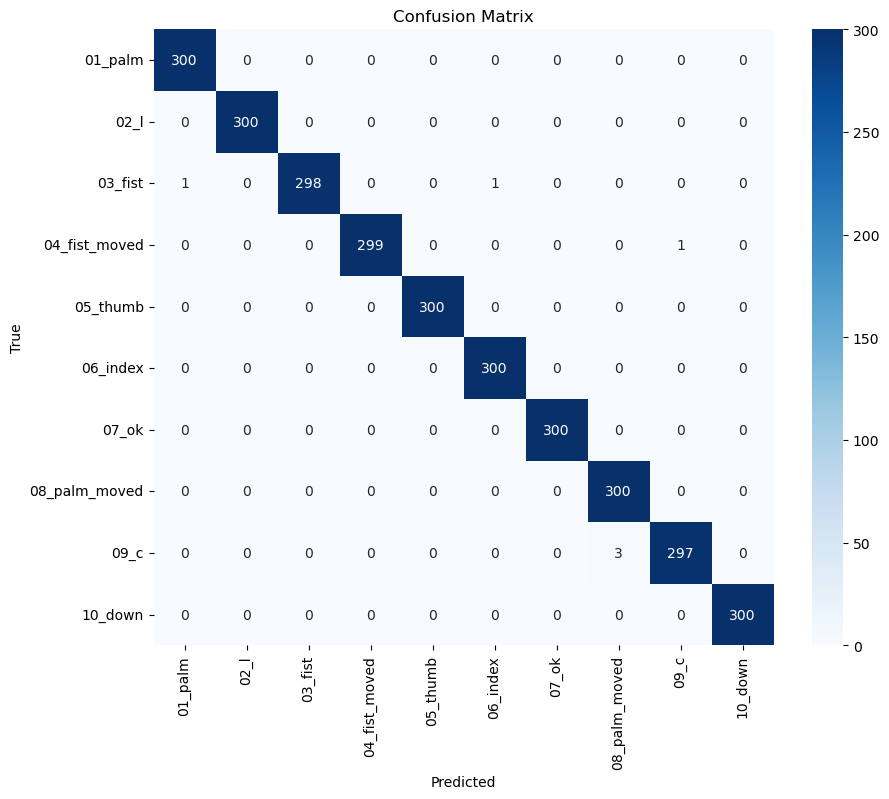

In [ ]:
cm = confusion_matrix(y_true_int, y_pred_int)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=target_names,
    yticklabels=target_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")

# Saving for MLflow
cm_path = "confusion_matrix.png"
plt.savefig(cm_path)

plt.show()

# **Deployment**

In [ ]:
mlflow.set_experiment("NEW_Hand_gesture ")

2025/12/10 21:55:32 INFO mlflow.tracking.fluent: Experiment with name 'NEW_Hand_gesture ' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:C:/Users/admin2/artifacts/4', creation_time=1765396532627, experiment_id='4', last_update_time=1765396532627, lifecycle_stage='active', name='NEW_Hand_gesture ', tags={}>

In [ ]:
mlflow.end_run()
with mlflow.start_run():
    mlflow.log_param("IMG_SIZE", IMG_SIZE)
    mlflow.log_param("batch_size", 64)
    mlflow.log_param("epochs", 15)
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("learning_rate", 0.0008)
    mlflow.log_param("model_arch", "3-conv-blocks + dense(256)")

🏃 View run nebulous-owl-736 at: http://localhost:5000/#/experiments/4/runs/a1b25df83951437ea5456c67573a77db
🧪 View experiment at: http://localhost:5000/#/experiments/4


In [ ]:
if "accuracy" in history.history:
    mlflow.log_metric("train_accuracy", float(history.history["accuracy"][-1]))
if "val_accuracy" in history.history:
    mlflow.log_metric("val_accuracy", float(history.history["val_accuracy"][-1]))
if "val_loss" in history.history:
    mlflow.log_metric("val_loss", float(history.history["val_loss"][-1]))

In [ ]:
# test metrics

mlflow.log_metric("test_accuracy", float(test_acc))
mlflow.log_metric("test_loss", float(test_loss))

# save and log classification report
with open("classification_report.txt", "w") as f:
    f.write(clf_report)
mlflow.log_artifact("classification_report.txt")

# log confusion matrix image
mlflow.log_artifact(cm_path)

# save & log label map
with open("label_map.json", "w") as f:
    json.dump({"label_lookup": label_lookup, "reverse_lookup": reverse_lookup}, f)
mlflow.log_artifact("label_map.json")

# log the keras model
mlflow.keras.log_model(model, "keras_model")

print("MLflow logging finished. Run `mlflow ui` to view runs.")

2025/12/10 22:08:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/10 22:08:15 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


MLflow logging finished. Run `mlflow ui` to view runs.
